In [2]:
import numpy as np
import os, sys
import tqdm
from tqdm import trange
from art.attacks.poisoning import GradientMatchingAttack
from art.utils import load_cifar10
from art.estimators.classification import PyTorchClassifier
from art.utils import to_categorical

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

/home/fabian/MasterStudium/PythonEnvironment/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from art.utils import load_cifar10

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # mps does not work
print(device)

cuda


In [5]:
import timm

def _create_model(model_name, classes):
    model = timm.create_model(MODEL_NAME, pretrained=True) # TODO Consider pretrained=True and False
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, classes) # adapt final layer to match the 10 classes of CIFAR-10

    return model

MODEL_NAME = "resnet18.a1_in1k"
model = _create_model(MODEL_NAME, 10)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')   # 32 --> 224, Faktor 7
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True) # from poisoning example

loss_fn = torch.nn.CrossEntropyLoss()

In [6]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

x_train = np.transpose(x_train, [0, 3,1,2])
x_test = np.transpose(x_test, [0, 3,1,2])

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

print (mean, std)

0.4733630004850874 0.25156892506322026


In [7]:
def data_processing(x_train, y_train, x_test, y_test, upsampler, device=device):
    
    if upsampler is None:
        x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
        x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor

    else:
        _x_tensor = torch.tensor(x_train, dtype=torch.float32, device=device) # transform to torch tensor
        x_tensor = upsampler(_x_tensor)
        del _x_tensor

        _x_tensor_test = torch.tensor(x_test, dtype=torch.float32, device=device) # transform to torch tensor
        x_tensor_test = upsampler(_x_tensor_test)
        del _x_tensor_test

    y_train = np.argmax(y_train, axis=1)
    y_tensor = torch.tensor(y_train, dtype=torch.long, device=device)

    y_test = np.argmax(y_test, axis=1)
    y_tensor_test = torch.tensor(y_test, dtype=torch.long, device=device)

    return x_tensor, y_tensor, x_tensor_test, y_tensor_test

In [8]:
x_train, y_train, x_test, y_test = data_processing(x_train, y_train, x_test, y_test, upsampler=None)


In [9]:
def _testAccuracy(model, test_loader, transform=None, max_steps=10):
    model_was_training = model.training
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data

            if transform is not None:
                images = transform(images)

            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    if model_was_training:
      model.train()
    return(accuracy)

In [10]:
def train_model(model, optimizer, loss_fn, x_train, y_train, x_test, y_test, x_trigger=None, y_trigger=None, transform=None, batch_size=128, epochs=80):
    
    model.to(device)

    dataset_train = TensorDataset(x_train.to(device), y_train.to(device)) # create your datset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size)

    dataset_test = TensorDataset(x_test.to(device), y_test.to(device)) # create your datset
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

    iter = trange(epochs)
    for _ in iter:
        running_loss = 0.0
        total = 0
        accuracy = 0
        for _, data in enumerate(dataloader_train, 0):
            inputs, labels = data
            optimizer.zero_grad()

            if transform is not None:
                outputs = model(transform(inputs))
            else:
                outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            running_loss += loss.item()
        train_accuracy = (accuracy / total)
        print ("train acc", train_accuracy)

        if x_trigger is not None:
            y_ = model(x_trigger)
            y_ = F.softmax(y_, dim=-1)[0]
            output_target = y_.detach().cpu().numpy()[y_trigger]
            iter.set_postfix({'acc': train_accuracy, 'target': output_target})
            tqdm.tqdm.write(str(output_target))
        else:
            iter.set_postfix({'acc': train_accuracy})
    test_accuracy = _testAccuracy(model, dataloader_test, transform)
    print("Final test accuracy: %f" % test_accuracy)

    del dataset_train, dataloader_train
    del dataset_test, dataloader_test

    return model

In [ ]:
model_checkpoint_path = './state_dicts/poison_%s_cifar10_model.pt' % MODEL_NAME
if os.path.isfile(model_checkpoint_path):
    checkpoint = torch.load(model_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])    
    print('loaded model checkpoint')
else:
    model = train_model(model, optimizer, loss_fn, x_train, y_train, x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')

print("Model and data preparation done.")



#### Poison the Dataset

In [13]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack
def poison_data(model, x_trigger, y_trigger, max_epochs = 100):
    epsilson = 16/255

    model_art = PyTorchClassifier(
        model=model,
        loss=loss_fn,
        optimizer=optimizer,    
        input_shape=(1, 28, 28),
        nb_classes=10,
    ) 

    attack = GradientMatchingAttack(model_art,
            percent_poison=0.10,
            max_trials=1,
            max_epochs=max_epochs,
            clip_values=(min_,max_),
            learning_rate_schedule=(np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), [250, 350, 400, 430, 460]),
            epsilon=epsilson,
            verbose=1)

    x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train.cpu(), y_train.cpu())
    return torch.tensor(x_poison), torch.tensor(y_poison)

In [12]:
target_class = 1
source_class = 0
target_indices = np.where(y_test.cpu().numpy() == source_class)[0][:10]

x_trigger = x_test[target_indices]
y_trigger  = to_categorical([target_class], nb_classes=10)

In [ ]:
import torch

x_poisons = []
y_poisons = []

for i in range(len(target_indices)):
    x_poison, y_poison = poison_data(model, x_trigger[i:i+1], y_trigger, max_epochs=500)
    x_poisons.append(x_poison)
    y_poisons.append(y_poison)

# Concatenate all the poisoned samples into a single tensor
x_poisons = torch.cat(x_poisons, dim=0)
y_poisons = torch.cat(y_poisons, dim=0)
torch.save((x_poisons, y_poisons), 'poisoned_data.pt')

In [15]:
x_poisons, y_poisons = torch.load('poisoned_data.pt')

print("Poisoned data loaded successfully")

Poisoned data loaded successfully


#### Train poisoned Models

In [ ]:
MODEL_NAME = "resnet18.a1_in1k"
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')   # 32 --> 224, Faktor 7
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True) # from poisoning example
loss_fn = torch.nn.CrossEntropyLoss()
models = []

for i in range(len(target_indices)):
    model_checkpoint_path = f'./state_dicts/poison_{MODEL_NAME}_cifar10_model_{i}.pt'

    model = _create_model(MODEL_NAME, 10)
    model = train_model(model, optimizer, loss_fn, x_poisons[50000*i:50000*(i + 1)], y_poisons[50000*i:50000*(i + 1)], x_test, y_test, transform=None, epochs=80)
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, model_checkpoint_path)
    print('saved model checkpoint')

    models.append(model)

#### Check Poison effectiveness

In [25]:
import torch
import numpy as np
from tqdm import tqdm  

poison_success_dict = {}
poison_fail_dict = {}

for i in range(len(target_indices)):
    model = _create_model(MODEL_NAME, 10).cuda()

    # import the model, training routines you need from your victim's code...
    model_path = f"./state_dicts/poison_resnet18.a1_in1k_cifar10_model_{i}.pt"
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict['model_state_dict'])
    # model.cuda()
    model.eval()
    poison_success = 0
    poison_fail = 0    

    for j in tqdm(range(50000*i,50000*(i+1)), desc=f"Processing model {i}"):
        test = torch.tensor(x_poisons[j:j+1], device=device, dtype=torch.float)
        
        y_ = model(test).cuda()
        
        y__np = y_.cpu().detach().numpy()          
        
        if np.argmax(y_trigger) == np.argmax(y__np):
            poison_success += 1
        else:
            poison_fail += 1
    
    poison_success_dict[i] = poison_success
    poison_fail_dict[i] = poison_fail

    del model
    torch.cuda.empty_cache()


Processing model 0:   0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_3692/2666724586.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(x_poisons[j:j+1], device=device, dtype=torch.float)
Processing model 9: 100%|██████████| 50000/50000 [01:43<00:00, 483.28it/s]


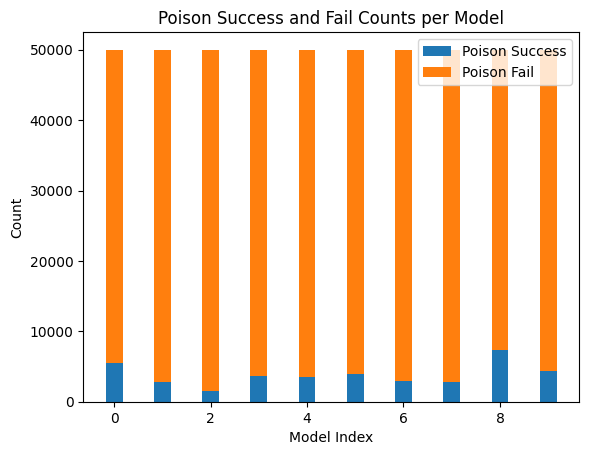

In [28]:
import matplotlib.pyplot as plt
indices = list(poison_success_dict.keys())
successes = list(poison_success_dict.values())
failures = list(poison_fail_dict.values())

fig, ax = plt.subplots()
bar_width = 0.35

bar1 = ax.bar(indices, successes, bar_width, label='Poison Success')
bar2 = ax.bar(indices, failures, bar_width, bottom=successes, label='Poison Fail')

ax.set_xlabel('Model Index')
ax.set_ylabel('Count')
ax.set_title('Poison Success and Fail Counts per Model')
ax.legend()

plt.show()